In [1]:
import pandas as pd
from pathlib import Path
from similarity_learning.loading_pipeline import LabeledPairsDataFrame
from similarity_learning.feature_engineering import BaselineFeatureExtractor
from similarity_learning.globals import (DEGREE_HIERARCHY_MAPPING,
                                         SENIORITY_HIERARCHY_MAPPING,
                                         LANGUAGE_RATING_HIERARCHY_MAPPING,
                                         LANGUAGE_MUST_HAVE_HIERARCHY_MAPPING)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from similarity_learning.inference import DecisionTreeModel
import numpy as np

### Decision Tree

From the knowledge aquired in the EDA we know that we can encode some of the features as multi-label binary vectors and for others it might be useful to encode some hierarchy, as we have external knowledge about these features. We also know that there is no column from the jobs dataset which has more items than the data in the talents dataset. So we will fit our encoders using the data from the talents ds.

In [2]:
data_path = Path("./data/raw_data.json")

In [3]:
data = LabeledPairsDataFrame.from_full_json(data_path, add_language_suffix=True)

In [4]:
feature_extractor = BaselineFeatureExtractor(
                         seniority_hierarchy_mapping=SENIORITY_HIERARCHY_MAPPING,
                         degree_hierarchy_mapping=DEGREE_HIERARCHY_MAPPING,
                         language_rating_hierarchy_mapping=LANGUAGE_RATING_HIERARCHY_MAPPING,
                         language_must_have_hierarchy_mapping=LANGUAGE_MUST_HAVE_HIERARCHY_MAPPING
                         )

In [5]:
features = feature_extractor.fit_transform(data)

similarity_learning - INFO - Computing seniority features:min required, max required, actual, difference from min required, and difference from max required.
similarity_learning - INFO - Computing salary features: difference.
similarity_learning - INFO - Computing seniority features: required, available, difference.
similarity_learning - INFO - Computing language features: rating difference and must have difference.
similarity_learning - INFO - Computing role features: difference, overall intersection.


In [6]:
features.shape

(2000, 133)

In [7]:
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
score = cross_val_score(decision_tree, features, data.labels, cv = 10)

In [8]:
pd.Series(score).describe()

count    10.000000
mean      0.985500
std       0.004378
min       0.980000
25%       0.981250
50%       0.985000
75%       0.990000
max       0.990000
dtype: float64

In [9]:
decision_tree = decision_tree.fit(features, data.labels)

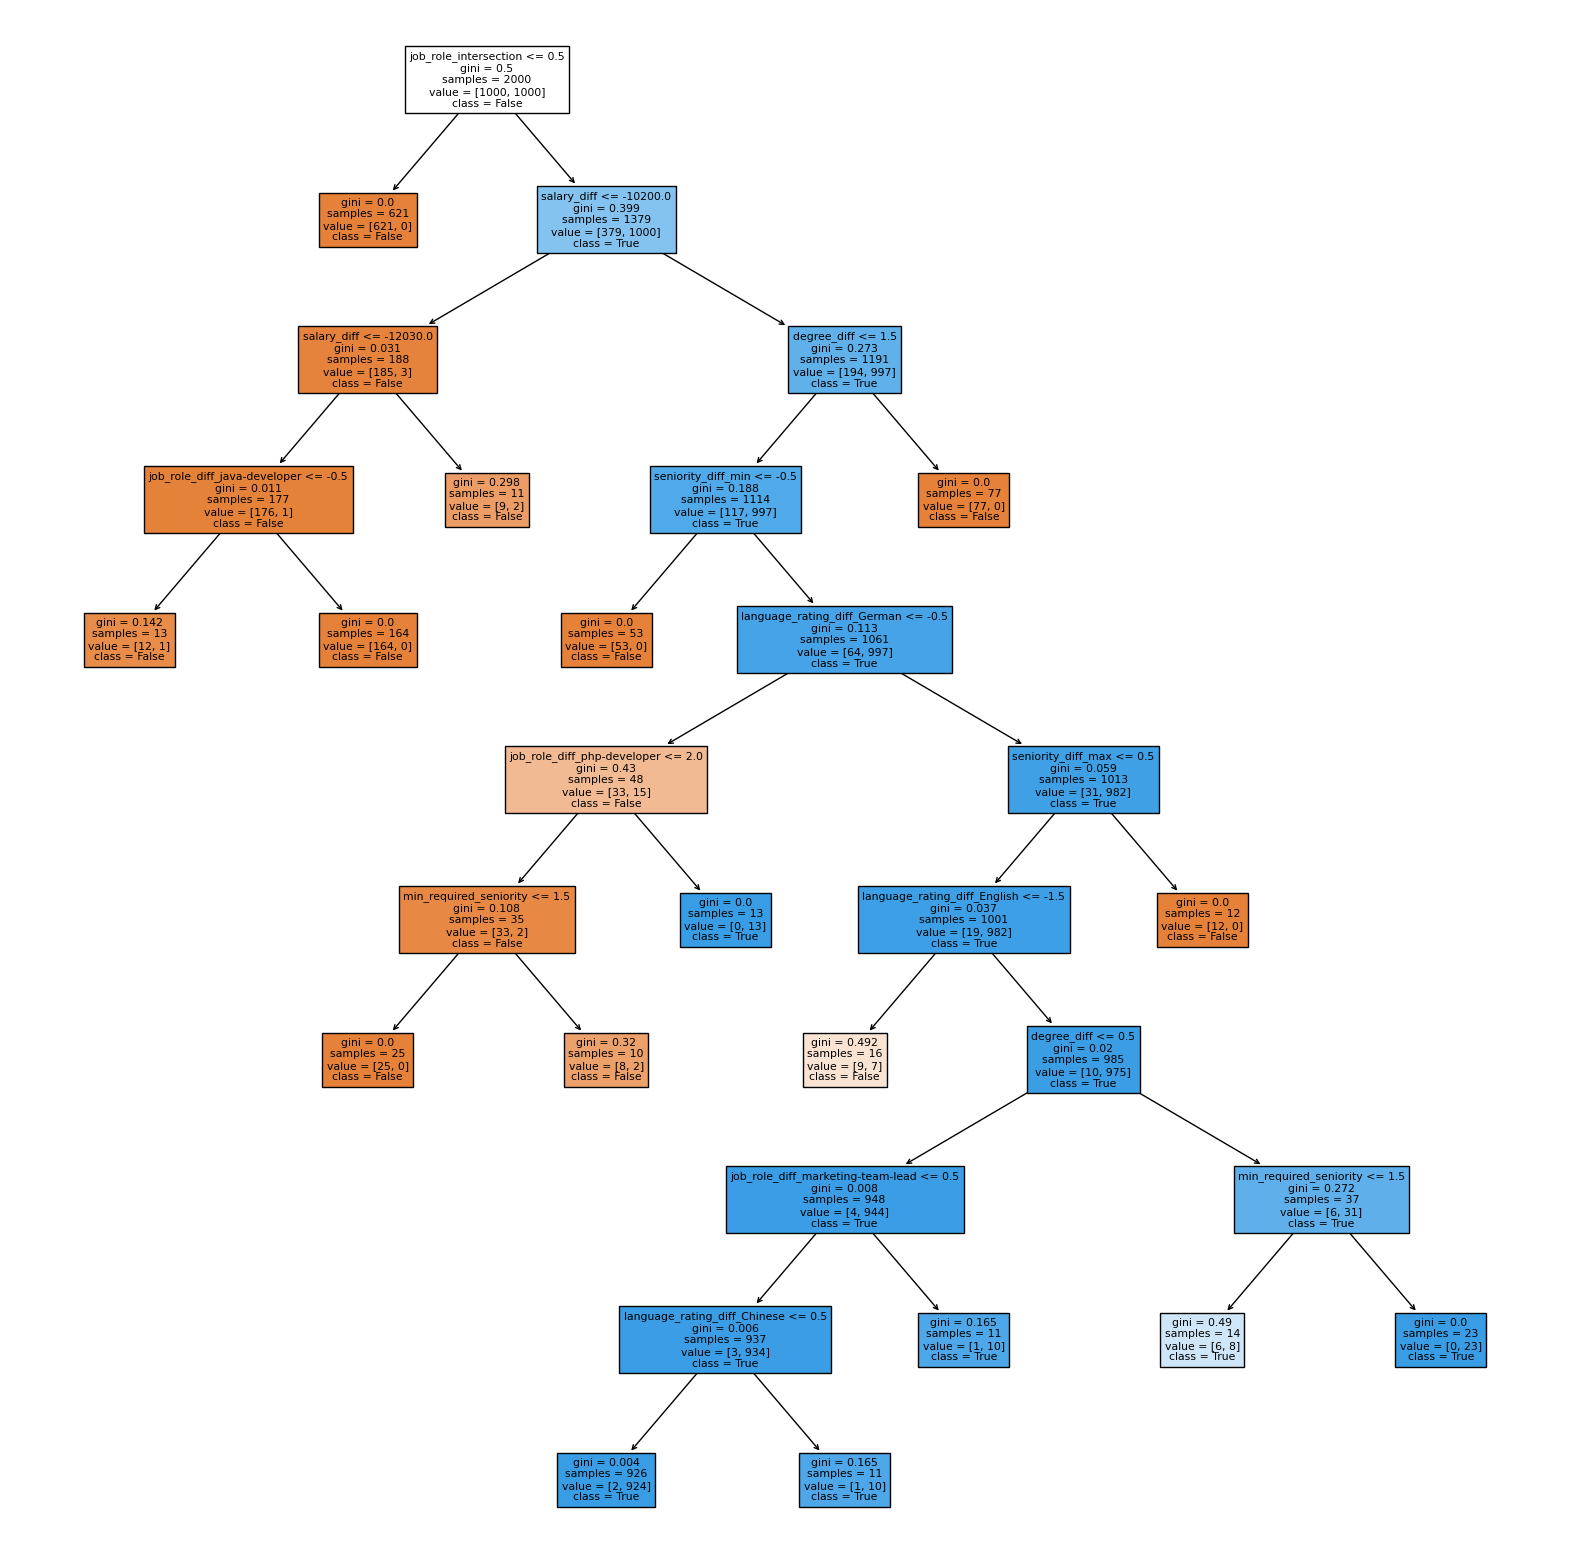

In [10]:
fig = plt.figure(figsize=(20,20))
_ = plot_tree(decision_tree, 
              feature_names=feature_extractor.feature_names,
              class_names=["False", "True"], 
             filled = True)


In [11]:
models_path = Path("stored_models/")

In [12]:
decision_tree_model = DecisionTreeModel(decision_tree, feature_extractor)

In [13]:
decision_tree_model.predict(data.iloc[0])

similarity_learning - INFO - Computing seniority features:min required, max required, actual, difference from min required, and difference from max required.
similarity_learning - INFO - Computing salary features: difference.
similarity_learning - INFO - Computing seniority features: required, available, difference.
similarity_learning - INFO - Computing language features: rating difference and must have difference.
similarity_learning - INFO - Computing role features: difference, overall intersection.


Similarity metric output: 
Labels: [True]
Similarity_scores: [0.99784017]

In [14]:
import pickle

In [15]:
with open(models_path / Path("decision_tree_sklearn.pkl"), 'wb') as f:
    pickle.dump(decision_tree, f)

In [16]:
with open(models_path / Path("decision_tree_model_object.pkl"), 'wb') as f:
    pickle.dump(decision_tree_model, f)